# **Area of interest - recommendation system**

Realizat de Neural Curators:

Cioraneanu Ioan, Protopopescu Theodor, Voiculescu Vlad Cristian si Zamfir Ruxandra Teodora

## Descrierea temei proiectului:

Proiectul are ca scop implementarea unui sistem de recomadare de articole stiintifice. Pe baza unui profil de utilizator dat, sistemul va recomanda acestuia articole stiintifice incadrate in aceeasi arie de interes cu cea sugerata de profilul sau. Resursa: https://en.wikiversity.org/wiki/Digital_Libraries/Recommender_systems. Aplicație trebuie să fie implmentată folosind platfroma Jupyter.

## Prezentarea setului de date CiteULike

In cadrul acestui proiect, utilizam setul de date **CiteULike-t** (disponibil la https://github.com/js05212/citeulike-t?tab=readme-ov-file), introdus initial in lucrarea *"Collaborative Topic Regression with Social Regularization"* (CTRSR) [1]. Acest set de date combina preferintele utilizatorilor de pe platforma CiteULike cu relatiile de citare extrase din Google Scholar.

**Statistici generale ale setului de date:**
* **Utilizatori:** 7.947
* **Articole (Items):** 25.975
* **Tag-uri:** 52.946
* **Citari:** 32.565

In continuare, detaliem structura fisierelor principale utilizate in procesarea datelor.

### 1. users.dat (Matricea de Rating)
Acest fisier contine interactiunile dintre utilizatori si articole, servind drept matrice de rating (implicit). Formatul asociaza fiecarui utilizator lista de articole pe care acesta le-a salvat in colectia personala.

> 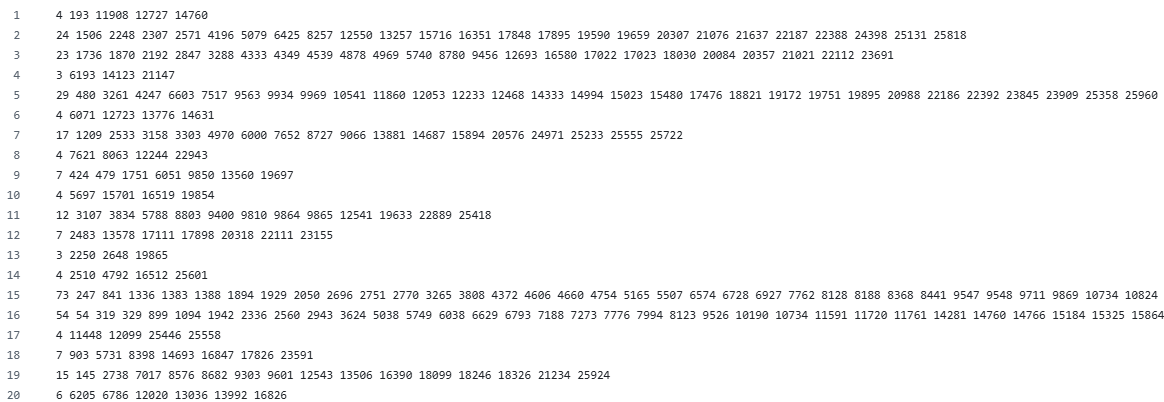
> *Figura 1: Exemplu de structura a fisierului users.dat*


### 2. rawtext.dat (Date Textuale Brute)
Fisierul contine informatiile textuale nestructurate ale articolelor. De regula, acestea includ titlul si abstractul lucrarii. Aceste date sunt esentiale pentru extragerea caracteristicilor semantice si pentru modelarea subiectelor (topic modeling).

> 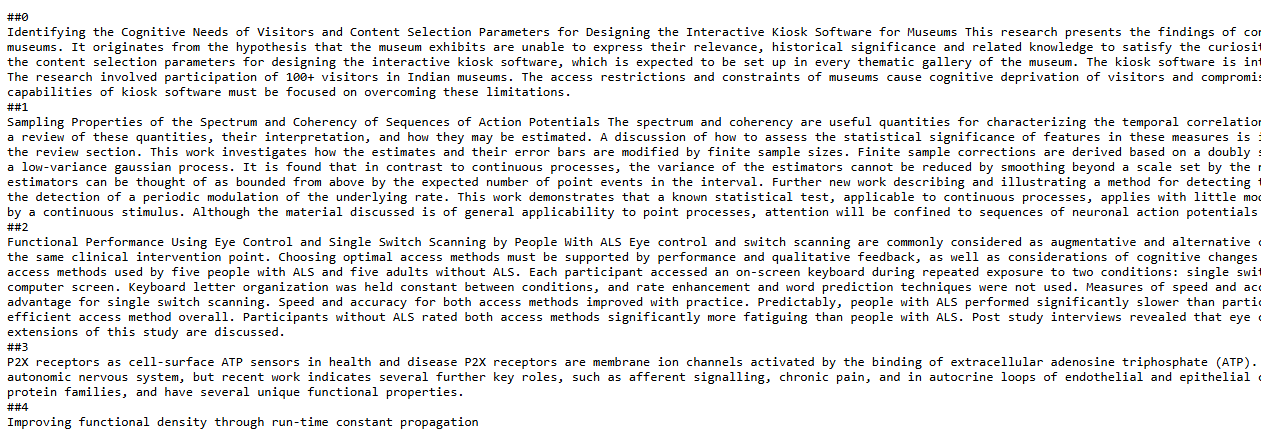
> *Figura 2: Exemplu de continut din rawtext.dat (Titlu si Abstract)*

### 3. citations.dat (Reteaua de Citari)
Acest fisier mapeaza relatiile de influenta stiintifica dintre articole, pe baza datelor din Google Scholar. Fiecare linie descrie conexiunile unui articol cu altele din baza de date (articole care il citeaza sau sunt citate de acesta).

> 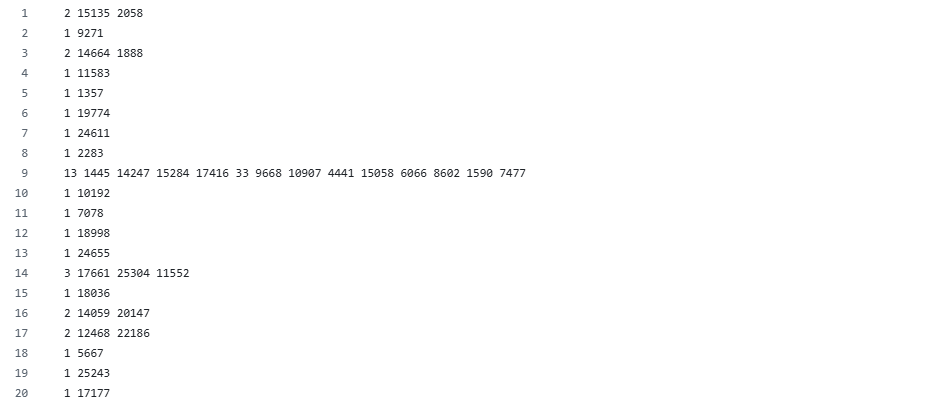
> *Figura 3: Exemplu de conexiuni in fisierul citations.dat*


### 4. tag-item.dat (Asociere Tag-Articol)
Fisierul grupeaza articolele pe baza etichetelor (tags) atribuite de utilizatori. Fiecare linie corespunde unui tag specific si contine lista de ID-uri ale articolelor asociate acelui tag. Acesta reprezinta versiunea bruta, inainte de pre-procesarea finala a tag-urilor.

> 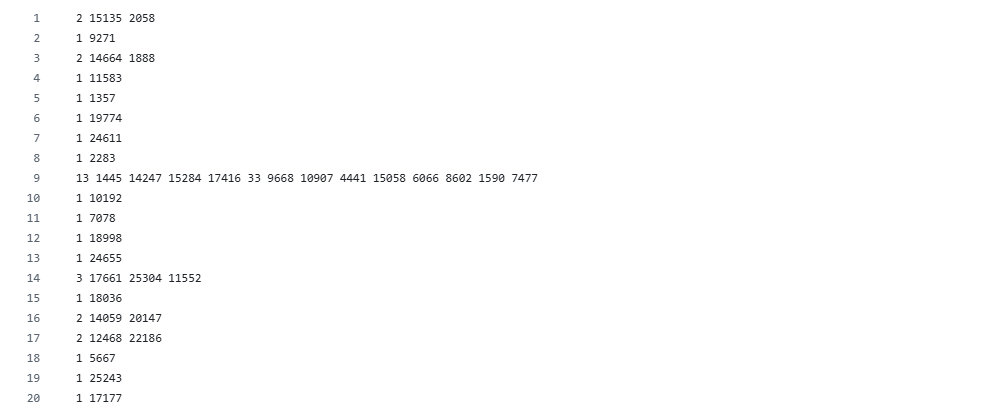
> *Figura 4: Gruparea articolelor in functie de tag-uri*

### Alte fisiere auxiliare

Pentru completitudine, mentionam si celelalte fisiere prezente in arhiva, utilizate in principal pentru pre-procesarea NLP:

* **mult.dat**: Reprezentarea de tip "bag-of-words" pentru fiecare articol.
* **vocabulary.dat**: Vocabularul de 20.000 de cuvinte cheie care corespunde indicilor din *mult.dat*.
* **tags.dat**: Lista simpla a tuturor tag-urilor, ordonata dupa ID.

[1] Wang, H., Chen, B., & Li, W. J. (2013, August). Collaborative topic regression with social regularization for tag recommendation. In IJCAI (Vol. 13, pp. 2719-2725).

## Instalare Biblioteci

Aceasta celula instaleaza bibliotecile Python necesare: `transformers` pentru modele de transformere, `pandas` pentru manipularea datelor, `scikit-learn` pentru functionalitati de machine learning si `torch` pentru construirea si antrenarea retelelor neuronale.

In [ ]:
!pip install transformers pandas scikit-learn torch

## Importuri si rulare pe GPU

Aceasta celula importa bibliotecile de baza necesare proiectului (`torch`, `torch.nn`, `torch.optim`, `torch.utils.data`, `pandas`, `numpy`, `os`, `sentence_transformers`, `sklearn.model_selection`). De asemenea, initializeaza dispozitivul de procesare (`DEVICE`) pentru a utiliza GPU (CUDA) daca este disponibil, altfel foloseste CPU.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

# Setări generale
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Rulare pe dispozitiv: {DEVICE}")

Rulare pe dispozitiv: cuda


## Functii de incarcare si preprocesare date

Aceasta celula defineste functiile esentiale pentru incarcarea si preprocesarea datelor:
- `CiteULikeDataset`: O clasa PyTorch `Dataset` pentru gestionarea datelor de interactiune utilizator-articol.
- `load_interactions`: Citeste datele de interactiune dintr-un fisier (`users.dat`), proceseaza si genereaza esantioane negative conform recomandarilor (cu 4 negative per pozitiv), asigurand o lista echilibrata de interactiuni pentru antrenare.
- `get_content_embeddings`: Extrage si cache-uieste embedding-urile textuale din abstractele articolelor folosind un model pre-antrenat Sentence-BERT (intfloat/multilingual-e5-large-instruct). Include logica de gestionare a fisierelor lipsa prin returnarea unor tensori de zero.
- `load_citations`: Proceseaza datele de citare ale articolelor dintr-un fisier intr-o matrice codificata multi-hot, determinand un vocabular al citarilor si construind matricea `features` unde `features[i, j] = 1.0` daca articolul `i` citeaza articolul `j`.
- `load_tags_optimized`: Optimizeaza utilizarea memoriei prin incarcarea doar a celor mai frecvente `max_vocab` (implicit 5000) tag-uri in o matrice codificata multi-hot, reducand semnificativ amprenta de memorie prin analizarea frecventei tag-urilor si remaparea ID-urilor vechi la noi.

In [ ]:
from collections import Counter

# Dataset pentru procesarea datelor
class CiteULikeDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __len__(self):
        return len(self.user_tensor)

    def __getitem__(self, idx):
        return self.user_tensor[idx], self.item_tensor[idx], self.target_tensor[idx]

# Citire si procesare matrice utilizator - articol
def load_interactions(file_path, num_negatives=4):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Nu am găsit fișierul {file_path}!")

    interact_list = []
    user_item_set = set()
    all_items = set()

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for u_id, line in enumerate(f):
            parts = list(map(int, line.strip().split()))
            if len(parts) < 1: continue
            items = parts[1:]

            for i_id in items:
                interact_list.append([u_id, i_id, 1])
                user_item_set.add((u_id, i_id))
                all_items.add(i_id)

    num_users = u_id + 1
    max_item_id = max(all_items) if all_items else 0
    num_items = max_item_id + 1
    final_list = interact_list.copy()

    for u, i, label in interact_list:
        negatives_seen = set()
        for _ in range(num_negatives):
            neg_item = np.random.randint(0, num_items)
            while (u, neg_item) in user_item_set or neg_item in negatives_seen:
                neg_item = np.random.randint(0, num_items)

            final_list.append([u, neg_item, 0])
            negatives_seen.add(neg_item)

    df = pd.DataFrame(final_list, columns=['user', 'item', 'label'])
    return df, num_users, num_items

# Procesare embedding-uri text
def get_content_embeddings(file_path, num_items, cache_file='content_emb.pt'):
    if os.path.exists(cache_file):
        print(f"[TEXT] Am gasit embeddings salvate în {cache_file}.")
        return torch.load(cache_file)

    if not os.path.exists(file_path):

        print(f"Nu am gasit {file_path}. Folosesc zero-uri.")
        return torch.zeros((num_items, 1068))

    id_to_text = {}
    current_id = None
    current_lines = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith("##"):
                if current_id is not None:
                    id_to_text[current_id] = " ".join(current_lines)
                try:
                    current_id = int(line[2:])
                    current_lines = []
                except ValueError:
                    if current_id is not None: current_lines.append(line)
            else:
                if current_id is not None: current_lines.append(line)
        if current_id is not None:
            id_to_text[current_id] = " ".join(current_lines)

    raw_texts = []
    for i in range(num_items):
        text = id_to_text.get(i, "")
        raw_texts.append(text)

    bert_model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
    embeddings_numpy = bert_model.encode(raw_texts, show_progress_bar=True, batch_size=32)

    content_tensor = torch.tensor(embeddings_numpy, dtype=torch.float32)
    torch.save(content_tensor, cache_file)
    return content_tensor

# Citire si procesare matrice de citari
def load_citations(file_path, num_items):

    feature_name = "Citations"
    if not os.path.exists(file_path):
        print(f"Nu am gasit {file_path}. Returnez matrice goala.")
        return torch.zeros((num_items, 1))

    print(f"[{feature_name}] Procesare fișier...")

    data_map = {}
    max_cited_id = 0

    with open(file_path, 'r') as f:
        for item_id, line in enumerate(f):
            if item_id >= num_items: break

            parts = list(map(int, line.strip().split()))
            if not parts: continue
            cited_ids = parts[1:]
            if cited_ids:
                local_max = max(cited_ids)
                max_cited_id = max(max_cited_id, local_max)
                data_map[item_id] = cited_ids


    vocab_size = max(num_items, max_cited_id + 1)
    features = torch.zeros((num_items, vocab_size), dtype=torch.float32)
    for item_id, c_ids in data_map.items():
        valid_ids = [x for x in c_ids if x < vocab_size]
        features[item_id, valid_ids] = 1.0

    return features

# Citire top 5000 tag-uri
def load_tags_optimized(file_path, num_items, max_vocab=5000):

    if not os.path.exists(file_path):
        return torch.zeros((num_items, 1))

    tag_counts = Counter()
    item_to_raw_tags = {} #

    with open(file_path, 'r') as f:
        for tag_id, line in enumerate(f):
            parts = list(map(int, line.strip().split()))
            if not parts: continue

            items = parts[1:]
            tag_counts[tag_id] = len(items)

            for item in items:
                if item < num_items:
                    if item not in item_to_raw_tags: item_to_raw_tags[item] = []
                    item_to_raw_tags[item].append(tag_id)

    top_tags = [t[0] for t in tag_counts.most_common(max_vocab)]

    old_to_new = {old: new for new, old in enumerate(top_tags)}
    features = torch.zeros((num_items, max_vocab), dtype=torch.float32)

    for item_id, raw_tags in item_to_raw_tags.items():
        for t in raw_tags:
            if t in old_to_new:
                new_id = old_to_new[t]
                features[item_id, new_id] = 1.0

    return features

## Definire arhitectură model HybridNeuMF

Aceasta celula defineste modelul `HybridNeuMF` (Hybrid Neural Matrix Factorization). Aceasta arhitectura de retea neurala personalizata combina:
- O ramura Multi-Layer Perceptron (MLP) care integreaza embedding-urile utilizatorilor si articolelor cu caracteristici de continut externe (text, tag-uri si citari). Aceasta include `nn.Embedding` pentru utilizatori si articole, proiectoare liniare (`nn.Linear`) pentru tag-uri si citari, si o secventa de straturi (`nn.Sequential`) cu `nn.Linear`, `nn.BatchNorm1d`, `nn.ReLU` si `nn.Dropout` pentru a procesa vectorul concatenat.
- O ramura Matrix Factorization (MF) care capteaza interactiunile factorilor latenti intre utilizatori si articole, folosind embedding-uri separate (`self.user_embed_mf`, `self.item_embed_mf`) si un produs element-wise (`*`) pentru a modela interactiunea MF.
Iesirile acestor doua ramuri sunt apoi concatenate (`final_vector`) si combinate printr-un strat final liniar si o functie de activare sigmoida pentru a produce un scor final de recomandare.

Arhitectura poate fi observata in Figura 5.

> 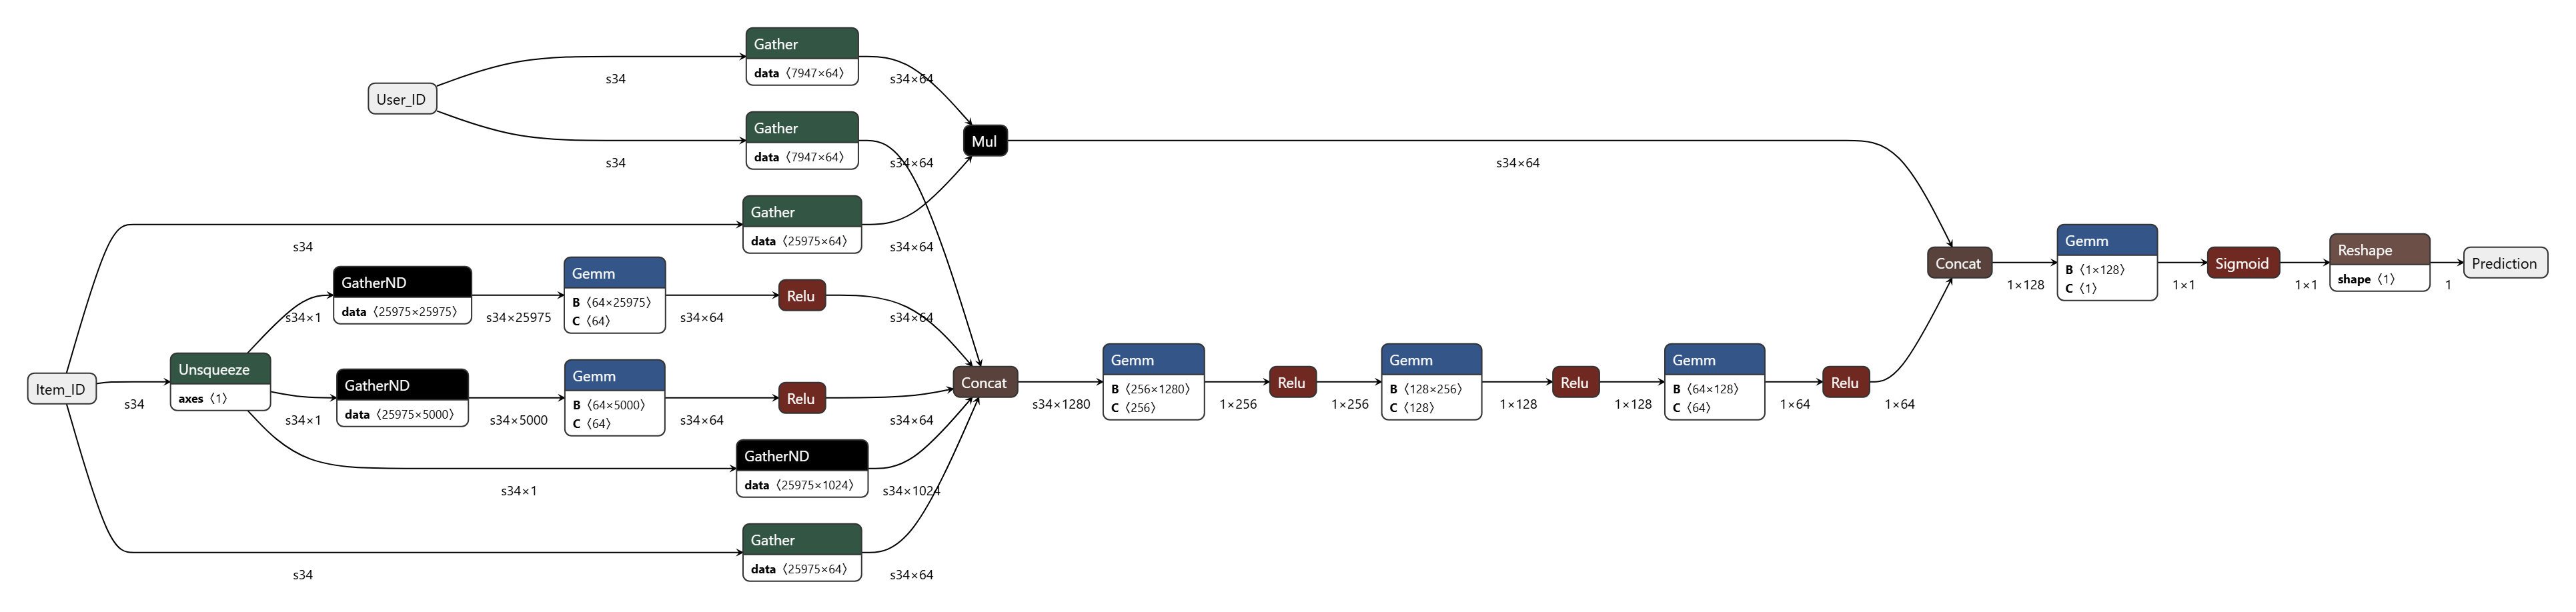
> *Figura 5: Arhitectura modelului HibrydNeuMF.*

In [ ]:
# Definirea arhitecturii modelului
class HybridNeuMF(nn.Module):
    def __init__(self, num_users, num_items,
                 text_matrix, tag_matrix, cit_matrix,
                 embed_size=64, layers=[256, 128, 64]):
        super(HybridNeuMF, self).__init__()

        self.user_embed_mlp = nn.Embedding(num_users, embed_size)
        self.item_embed_mlp = nn.Embedding(num_items, embed_size)


        self.register_buffer('text_feat', text_matrix)
        self.register_buffer('tag_feat', tag_matrix)
        self.register_buffer('cit_feat', cit_matrix)


        text_dim = text_matrix.shape[1]
        tag_dim = tag_matrix.shape[1]
        cit_dim = cit_matrix.shape[1]
        self.tag_projector = nn.Linear(tag_dim, embed_size)
        self.cit_projector = nn.Linear(cit_dim, embed_size)
        input_dim_mlp = embed_size * 2 + text_dim + embed_size * 2

        fc_modules = []
        for hidden_dim in layers:
            fc_modules.append(nn.Linear(input_dim_mlp, hidden_dim))
            fc_modules.append(nn.BatchNorm1d(hidden_dim))
            fc_modules.append(nn.ReLU())
            fc_modules.append(nn.Dropout(0.5))
            input_dim_mlp = hidden_dim
        self.fc_layers = nn.Sequential(*fc_modules)
        self.user_embed_mf = nn.Embedding(num_users, embed_size)
        self.item_embed_mf = nn.Embedding(num_items, embed_size)
        final_dim = layers[-1] + embed_size
        self.output_layer = nn.Linear(final_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_idx, item_idx):
        u_mlp = self.user_embed_mlp(user_idx)
        i_mlp = self.item_embed_mlp(item_idx)
        txt_vec = self.text_feat[item_idx]
        tag_vec = torch.relu(self.tag_projector(self.tag_feat[item_idx]))
        cit_vec = torch.relu(self.cit_projector(self.cit_feat[item_idx]))
        vector_mlp = torch.cat([u_mlp, i_mlp, txt_vec, tag_vec, cit_vec], dim=-1)
        out_mlp = self.fc_layers(vector_mlp)
        u_mf = self.user_embed_mf(user_idx)
        i_mf = self.item_embed_mf(item_idx)
        out_mf = u_mf * i_mf
        final_vector = torch.cat([out_mlp, out_mf], dim=-1)
        pred = self.output_layer(final_vector)
        return self.sigmoid(pred).view(-1)


## Configurarea și încărcarea inițială a datelor

Aceasta celula configureaza setarile initiale pentru antrenarea modelului, incluzand caile fisierelor pentru date (`FILES`) si hiperparametri precum `EMBED_SIZE`, `BATCH_SIZE`, `EPOCHS` si `LR`. Ulterior, incarca datele de interactiune utilizator-articol folosind functia `load_interactions` si genereaza embedding-urile textuale pentru articole prin apelarea `get_content_embeddings`.De asemenea, incarca si preproceseaza datele de tag-uri si citari ale articolelor.

In [ ]:
FILES = {
    'users': 'users.dat',
    'text': 'rawtext.dat',
    'tags': 'tag-item.dat',
    'citations': 'citations.dat'
}

EMBED_SIZE = 64
BATCH_SIZE = 256
EPOCHS = 10
LR = 0.001

try:
    df, n_users, n_items = load_interactions(FILES['users'])
except FileNotFoundError as e:
    print(f"EROARE: {e}")

try:
    text_matrix = get_content_embeddings(FILES['text'], n_items)
except Exception as e:
    print(f"Eroare Text: {e}")

tag_matrix = load_tags_optimized(FILES['tags'], n_items)
cit_matrix = load_citations(FILES['citations'], n_items)

for name, matrix in [("Text", text_matrix), ("Tags", tag_matrix), ("Cit", cit_matrix)]:
    if matrix.shape[0] != n_items:
        print(f"Resize {name} de la {matrix.shape[0]} la {n_items}")
        if matrix.shape[0] < n_items:
            padding = torch.zeros((n_items - matrix.shape[0], matrix.shape[1]))

            pass

def fix_size(mat, target_n):
    if mat.shape[0] < target_n:
        pad = torch.zeros((target_n - mat.shape[0], mat.shape[1]))
        return torch.cat([mat, pad], dim=0)
    return mat[:target_n]

[TEXT] Am gasit embeddings salvate în content_emb.pt.
[Citations] Procesare fișier...


In [ ]:
torch.cuda.empty_cache()

## Preprocesarea caracteristicilor, antrenarea și validarea

Aceasta celula imparte datele de interactiune in seturi de antrenare si validare (`train_test_split`), initializeaza modelul `HybridNeuMF` cu toate caracteristicile externe, defineste functia de pierdere Binary Cross-Entropy (`nn.BCELoss`) si un optimizator Adam. In final, executa bucla de antrenare pe parcursul mai multor epoci, valideaza modelul pe setul de validare si salveaza ponderile modelului cu cea mai buna performanta (cea mai mica pierdere de validare) intr-un fisier numit 'best_model_citeulike_full.pth'.


In [ ]:
text_matrix = fix_size(text_matrix, n_items)
tag_matrix = fix_size(tag_matrix, n_items)
cit_matrix = fix_size(cit_matrix, n_items)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_ds = CiteULikeDataset(
    torch.LongTensor(train_df['user'].values),
    torch.LongTensor(train_df['item'].values),
    torch.FloatTensor(train_df['label'].values)
)
val_ds = CiteULikeDataset(
    torch.LongTensor(val_df['user'].values),
    torch.LongTensor(val_df['item'].values),
    torch.FloatTensor(val_df['label'].values)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


print("Initializare model Hybrid NCF (Text + Tags + Citations)...")
model = HybridNeuMF(n_users, n_items,
                  text_matrix, tag_matrix, cit_matrix,
                  embed_size=EMBED_SIZE).to(DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
best_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for u, i, label in train_loader:
        u, i, label = u.to(DEVICE), i.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()
        prediction = model(u, i)
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for u, i, label in val_loader:
            u, i, label = u.to(DEVICE), i.to(DEVICE), label.to(DEVICE)
            pred = model(u, i)
            v_loss = criterion(pred, label)
            val_loss += v_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_citeulike_full.pth")
print("Antrenare finalizata.")



Initializare model Hybrid NCF (Text + Tags + Citations)...
Epoch 1/10 | Train Loss: 0.4437 | Val Loss: 0.3995
Epoch 2/10 | Train Loss: 0.3743 | Val Loss: 0.3316
Epoch 3/10 | Train Loss: 0.3135 | Val Loss: 0.2721
Epoch 4/10 | Train Loss: 0.2671 | Val Loss: 0.2475
Epoch 5/10 | Train Loss: 0.2427 | Val Loss: 0.2371
Epoch 6/10 | Train Loss: 0.2284 | Val Loss: 0.2270
Epoch 7/10 | Train Loss: 0.2186 | Val Loss: 0.2234
Epoch 8/10 | Train Loss: 0.2119 | Val Loss: 0.2213
Epoch 9/10 | Train Loss: 0.2057 | Val Loss: 0.2208
Epoch 10/10 | Train Loss: 0.2014 | Val Loss: 0.2198
Antrenare finalizata.


## Functii de inferenta si recomandare

Aceasta celula contine functii pentru realizarea recomandarilor si demonstreaza modul de utilizare a modelului antrenat pentru inferenta. Include `load_titles` pentru incarcarea titlurilor articolelor din `rawtext.dat` si afisarea rezultatelor intr-un format lizibil, si `recommend_for_user` care genereaza Top K recomandari prin identificarea articolelor nevazute de un utilizator, pregatirea tensorilor pentru model si prezicerea scorurilor. Functia `run_inference_demo` este responsabila de reincarcarea datelor de interactiune, a titlurilor, a matricilor de caracteristici (`text_emb`, `tag_matrix`, `cit_matrix`) si a ponderilor antrenate ale modelului ('best_model_citeulike_full.pth'), apoi genereaza si afiseaza recomandarile de top pentru un utilizator specific, impreuna cu istoricul sau de interactiuni.

In [ ]:
# Citirea titlurilor articolelor
def load_titles(file_path):
    id_to_title = {}
    current_id = None
    first_line_of_item = True

    if not os.path.exists(file_path):
        return {}

    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.strip()
            if not line: continue

            if line.startswith("##"):
                try:
                    current_id = int(line[2:])
                    first_line_of_item = True
                except:
                    pass
            elif current_id is not None and first_line_of_item:

                id_to_title[current_id] = line
                first_line_of_item = False

    return id_to_title

# Generarea top-k recomandari de articole pentru userul cu user-id
def recommend_for_user(model, user_id, interact_df, total_items, top_k=10):

    model.eval()
    seen_items = set(interact_df[interact_df['user'] == user_id]['item'].values)
    all_indices = np.arange(total_items)
    candidates = [x for x in all_indices if x not in seen_items]
    if not candidates:
        return [], []

    candidates_tensor = torch.LongTensor(candidates).to(DEVICE)
    user_tensor = torch.LongTensor([user_id] * len(candidates)).to(DEVICE)
    with torch.no_grad():

        predictions = model(user_tensor, candidates_tensor)

    sorted_score_indices = torch.argsort(predictions, descending=True)[:top_k]
    top_item_ids = candidates_tensor[sorted_score_indices].cpu().numpy()
    top_scores = predictions[sorted_score_indices].cpu().numpy()

    return top_item_ids, top_scores


def run_inference_demo():
    df, n_users, n_items = load_interactions(FILES['users'])
    positive_df = df[df['label'] == 1]
    titles_map = load_titles(FILES['text'])
    print("Reincarcare features pentru model...")
    text_emb = torch.load('content_emb.pt', map_location=DEVICE)
    tag_matrix = load_tags_optimized(FILES['tags'], n_items).to(DEVICE)
    cit_matrix = load_citations(FILES['citations'], n_items).to(DEVICE)
    model = HybridNeuMF(n_users, n_items, text_emb, tag_matrix, cit_matrix).to(DEVICE)
    try:
        model.load_state_dict(torch.load("best_model_citeulike_full.pth"))
        print("Model antrenat incarcat cu succes!")
    except FileNotFoundError:
        return

    target_user = 14
    print(f"\nGenerare recomandari pentru User {target_user}...")
    history = positive_df[positive_df['user'] == target_user]['item'].values
    print(f"Istoric utilizator ({len(history)} articole citite):")
    for i in history[:5]:
        print(f" - [{i}] {titles_map.get(i, 'Titlu necunoscut')}")

    top_k = 10
    rec_ids, rec_scores = recommend_for_user(model, target_user, positive_df, n_items, top_k=top_k)
    print(f"\nTop {top_k} Recomandari (ce ar trebui să citeasca):")
    for i, score in zip(rec_ids, rec_scores):
        title = titles_map.get(i, "Titlu indisponibil")
        print(f" Scor {score:.4f} -> [{i}] {title}")

if __name__ == "__main__":
    run_inference_demo()


Reincarcare features pentru model...
[Citations] Procesare fișier...
Model antrenat incarcat cu succes!

Generare recomandari pentru User 14...
Istoric utilizator (73 articole citite):
 - [247] QXP: powerful, rapid computer algorithms for structure-based drug design. New methods for docking, template fitting and building pseudo-receptors are described. Full conformational searches are carried out for flexible cyclic and acyclic molecules. QXP (quick explore) search algorithms are derived from the method of Monte Carlo perturbation with energy minimization in Cartesian space. An additional fast search step is introduced between the initial perturbation and energy minimization. The fast search produces approximate low-energy structures, which are likely to minimize to a low energy. For template fitting, QXP uses a superposition force field which automatically assigns short-range attractive forces to similar atoms in different molecules. The docking algorithms were evaluated using X-ray d